#COMP 565: Assignment 4 - unsupervised learning of single-cell transcriptome data using NMF and ETM

In this assignment, you will directly modify the code blocks as instructed below to implement and experiment non-negative matrix factorization (NMF) and embedded topic model (ETM) on a single-cell RNA-seq datasets.

For the rest of the codeblocks, simply click through them **without making any change**. You need to read and understand each codeblock. But we will only grade the assigned code blocks and the desired outputs.

You are recommended to run the code using Colab. By the default Colab connects to a CPU node. To speed up the training, you may connect with a T4 GPU by choosing 'Runtime' in the top menu and then clicking on 'Change runtime type' and choose 'T4 GPU'. Note that for free Google account, we can keep the notebook connected to a GPU for at most 12 hours. Nonetheless, all the training and inference required to complete this assignment can be done within 5 minutes even with a CPU.

If you have a good GPU-equipped Windows or Mac computer, you may connect to Local Runtime:

1. Install Jupyter Package for Colab: in Terminal with bash shell, do

  ```
  pip install jupyter_http_over_ws
  jupyter serverextension enable --py jupyter_http_over_ws
  ```
  
2. In Terminal, start a Jupyter Notebook instance on your local machine:
```
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --no-browser
```
Copy one of the URLs generated as a token. From my side, it looks like this `http://localhost:8888/?token=[long string]`

3. Connect to Local Runtime in Colab:
  1. Open your Colab notebook and select Connect → Connect to local runtime.
  2. When prompted with local URL, paste the token URL you got from step 2.

After this setup, Colab will connect to the local Jupyter Notebook server, allowing you to utilize your local machine's resources while running the notebook on Google Colab's interface.

In my experiments, I used a Macbook Pro with M1 Max and 64 GB RAM. The speed is comparable to the T4 GPU and much faster than the default CPU on Colab.


In [ ]:
#@title Install scanpy for single-cell data analysis
!pip install scanpy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.7/141.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 4.1 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=2aa5ed6f14cd4dd4a0aff9a950463939dacb079605536310e38919288dd9508b
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [ ]:
#@title Install igraph and louvain needed for clustering evaluation below
!pip install python-igraph
!pip install louvain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.6 MB/s eta 0:00:00


In [ ]:
#@title Import all required libraries for this assignment
import pickle
import numpy as np
import pandas as pd

import scanpy as sc
import anndata
import random

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F

import os
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from seaborn import heatmap, lineplot, clustermap
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
import igraph as ig
import louvain as lv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(10)

/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/usr

# Mouse Pancreas single-cell RNA-sequencing data
The folder a4_data contains the single-cell Mouse Pancreas dataset obtained from Baron et al (2016) study. The dataset has 1886 cells measured over 4194 genes by scRNA-seq and were processed and filtered for the purpose of this assignment. Here are the individual files:

* `MP.pickle`: The single-cell expression count matrix (matrix of integers) of dimension 1886 cells by 4194 genes plus 2 columns indicating the batch IDs and cell types
* `MP_genes.pickle`: gene names for the 4194 genes
* `sample_info.csv`: a 1886 by 3 information matrix with the rows as the1886 cells and columns for the cell IDs, batch IDs (not used in this assignment), and cell type labels
* `cell_IDs.pkl`: cell IDs as a list of strings

The code block below loads the scRNA-seq data into a Pandas DataFrame `df` as well as the M gene names `genes` using a Python library called `pickle`. It then reorders the rows and columns and save the final $N\times M$ matrix $X$ into a Numpy `ndarray` for our subsequent matrix factorization tasks.

In addition, using `anndata` library we create an AnnData object called `mp_anndata`, which as the input ndarray matrix $X$ and the ground-truth cell type labels for the 1886 cells for evaluation purpose.

In [ ]:
# If run on Colab cloud compute (default), uncomment this code
from google.colab import drive
drive.mount('/content/drive')
# change this to the path where a4_data is saved on your Google Drive
filepath = "/content/drive/My Drive/a4_data/"

# If running on local runtime, uncomment this change the file path if needed
# filepath = "~/a4_data/"
# filepath = os.path.expanduser(filepath)

# mouse pancreas single-cell dataset
# read in data and cell type labels
with open(filepath+'MP.pickle', 'rb') as f:
    df = pickle.load(f)

with open(filepath+'MP_genes.pickle', 'rb') as f:
    genes = pickle.load(f)

df.set_index('Unnamed: 0', inplace=True)  # set first column (cell ID as the index column)
sample_id = pickle.load(open(filepath+'cell_IDs.pkl', 'rb'))
df = df.loc[list(sample_id), :]

X = df[genes].values  # extract the N x M cells-by-genes matrix

sample_info = pd.read_csv(filepath+'sample_info.csv')

mp_anndata = anndata.AnnData(X=X)

mp_anndata.obs['Celltype'] = sample_info['assigned_cluster'].values

N = X.shape[0]  # number of single-cell samples
K = 16  # number of topics
M = X.shape[1]  # number of genes

X_tensor = torch.from_numpy(np.array(X, dtype="float32"))
sums = X_tensor.sum(1).unsqueeze(1)
X_tensor_normalized = X_tensor / sums

Mounted at /content/drive


# Evaluating clustering by adjusted Rand Index
Adjusted Rand Index (ARI) is a common metric used to evaluate the unsupervised clustering by comparing the consistency between the predicted clusters and the ground-truth clusters (i.e., cell type labels in this assignment).

The function `evaluate_ari(cell_embed, adata)` below takes $N\times K$ input cell embedding `cell_embed` with $K$ as the embedding dimensions and the annotated cell label data as `adata`. It first runs UMAP to compute the distance between cells based on their embeddings and then run Louvain clustering using the cells-cells distance matrix from UMAP to cluster cells into groups defined by the resolution parameter (default: 0.15). Finally, it computes the ARI based on the Louvain clusters and the ground-truth cell type using `adjusted_rand_score` from `Scikit-learn`.

We will be using `evaluate_ari` to evaluate the cell embedding quality by NMF and ETM.

In [ ]:
def evaluate_ari(cell_embed, adata):
    """
        This function is used to evaluate ARI using the lower-dimensional embedding
        cell_embed of the single-cell data
        :param cell_embed: a NxK single-cell embedding generated from NMF or scETM
        :param adata: single-cell AnnData data object (default to to mp_anndata)
        :return: ARI score of the clustering results produced by Louvain
    """
    adata.obsm['cell_embed'] = cell_embed
    sc.pp.neighbors(adata, use_rep="cell_embed", n_neighbors=30)
    sc.tl.louvain(adata, resolution=0.15)
    ari = adjusted_rand_score(adata.obs['Celltype'], adata.obs['louvain'])
    return ari

# A4 Task 1 (1 point) NMF with SSE loss

Implement the NMF function `nmf_sse` based on Lecture 13 slide 19. A function header, Docstring, and function call have been written for you.

Your implementation can be in either Numpy or PyTorch. The latter is much faster when running on a GPU.

Note that the NMF takes an input matrix of dimension $M\times N$ with $M$ genes and $N$ samples whereas the input matrix $X$ is a $N\times M$ dimension. Also, the matrix $H$ is a $K\times N$ matrix where the `evaluate_ari(cell_embed, adata)` above expects the cell embedding to have dimension $N\times K$. So you will need to provide these functions with the transposed of $X$ and $H$, respectively.

Besides returning the final matrices $W$ and $H$, save the mean squared error (MSE) $MSE = ||X-WH||_2^2/(N*M)$ and ARI at each iteration into a 3-column ndarray called `perf` with the first column as the iteration index and return `perf` as the third output from the function `nmf_sse`.

Run your NMF for 100 iterations and return $W$, $H$, and `perf` for the following analyses. This should take less than 3 minutes depending on your local computer. This should takes less than a minute to finish.

In [ ]:
#@title NMF with SSE loss function
def nmf_sse(X, K, adata=mp_anndata, niter=100):
    """
    NMF with sum of squared error loss as the objective
    :param X: M x N input matrix (numpy array)
    :param K: low rank
    :param adata: annotated X matrix with cluster labels for evaluating ARI
    :param niter: number of iterations to run
    :return:
        1. updated W and H that minimize sum of squared error ||X - WH||^2_F s.t. W,H>=0
        2. niter-by-3 tensor with iteration index, SSE, and ARI as the 3 columns
    """

    # Initialize W and H with random values, ensuring they're on the GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    M, N = X.shape
    W = torch.rand(M, K, device=device)
    H = torch.rand(K, N, device=device)
    X = torch.from_numpy(np.array(X, dtype="float32"))

    # Ensure X, W, and H are on the correct device
    X = X.to(device)
    W = W.to(device)
    H = H.to(device)

    # Initialize performance tracking array
    perf = torch.zeros((niter, 3), dtype=torch.float32, device=device)


    # COMPLETE THIS FUNCTION
    for i in range(niter):
      H = H*(W.T@X)/(W.T@W@H)
      W = W*(X@H.T)/(W@H@H.T)
      perf[i, 0] = i
      perf[i, 1] = torch.sum((X-W@H)**2/(N*M))
      perf[i, 2] = evaluate_ari(H.T.cpu().numpy(), adata)



    return W.cpu().numpy(), H.cpu().numpy(), perf.cpu()

In [ ]:
W_nmf_sse, H_nmf_sse, nmf_sse_perf = nmf_sse(X.T, K, niter=100)

# Monitor training progress
THe function called `monitor_perf` below is completed and provided to you. It displays the SSE and ARI at each iteration from the above NMF-SSE training. If your above NMF implementation is correct, you will observe that the SSE drops quite rapidly at the first few iterations and the ARI increases in a zigzag way because it is an independent metric from the training objective.

Use plot below as your reference. Although you may see a different progress with different random initialization of $W$ and $H$, the behaviour of your implemented NMF model should be very similar and this is true for all of the following tasks.

We are going to use `monitor_perf` to monitor the performances of the other two models that we are going to implement next.

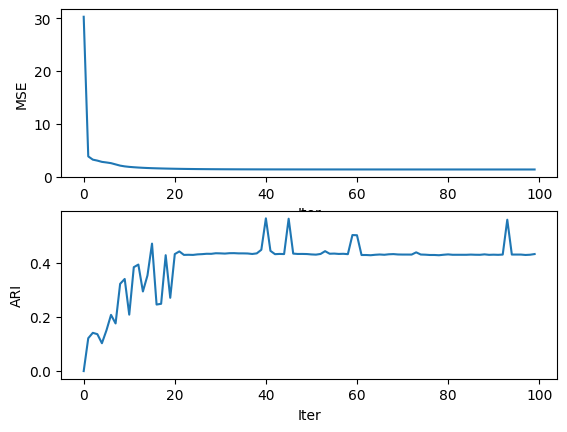

In [ ]:
#@title Monitor ARI and objective function
def monitor_perf(perf, objective, path=""):
    """
    :param perf: niter-by-3 ndarray with iteration index, objective function, and ARI as the 3 columns
    :param objective: 'SSE', 'Poisson', or 'NELBO'
    :param path: path to save the figure if not display to the screen
    :behaviour: display or save a 2-by-1 plot showing the progress of optimizing objective and ARI as
        a function of iterations
    """
    perf = pd.DataFrame(data=perf, columns=['Iter', objective, 'ARI'])
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharey=False)
    lineplot(data=perf, x="Iter", y=objective, ax=ax1)
    lineplot(data=perf, x="Iter", y="ARI", ax=ax2)
    if path == "":
        plt.show()
    else:
        plt.savefig(path)

monitor_perf(nmf_sse_perf, "MSE")

# A4 Task 2 (2 points) NMF with log Poisson likelihood
Implement the NMF function `nmf_psn` that maximizes the log Poisson likelihood w.r.t. $W$ and $H$ s.t. $W,H\ge0$ based on Lecture 13 slide 53.

Your implementation can be in either Numpy or PyTorch. The latter is much faster when running on a GPU.

Save the average log Poisson likelihood $(X\log WH - WH)/(N\times M)$ and ARI at each iteration.

Note that because the NMF algorithm requires element-wise division, to avoid dividing by zeros, you can set the zero values to a small value like so: `np.where(A > 0, A, 1e-16)`.


In [ ]:
#@title NMF Poisson likelihood
def nmf_psn(X, K, adata=mp_anndata, niter=100):
    """
    NMF with log Poisson likelihood as the objective
    :param X: M x N input matrix
    :param K: low rank
    :param adata: annotated X matrix with cluster labels for evaluating ARI
    :param niter: number of iterations to run
    :return:
        1. updated W and H that minimize log Poisson likelihood
        2. niter-by-3 tensor with iteration index, Loglik, and ARI as the 3 columns
    """
    # Initialize W and H with random values, ensuring they're on the GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    M, N = X.shape
    W = torch.rand(M, K, device=device)
    H = torch.rand(K, N, device=device)
    X = torch.from_numpy(np.array(X, dtype="float32"))

    # Ensure X, W, and H are on the correct device
    X = X.to(device)
    W = W.to(device)
    H = H.to(device)

    #Avoiding to divide by zeroes
    W = torch.where(W > 0, W, torch.tensor(1e-16, device=device))
    H = torch.where(H > 0, H, torch.tensor(1e-16, device=device))
    X = torch.where(X > 0, X, torch.tensor(1e-16, device=device))

    # Initialize performance tracking array
    perf = torch.zeros((niter, 3), dtype=torch.float32, device=device)

    # COMPLETE THIS FUNCTION
    for i in range(niter):
      W = W * ((X / (W @ H)) @ H.T) / (torch.ones(M, N, device=device) @ H.T)
      H = H * (W.T @ (X / (W @ H))) / (W.T @ torch.ones(M, N, device=device))
      likelihood = ((X * torch.log(W @ H) - W @ H).sum()) / (N * M)
      perf[i, 0] = i
      perf[i, 1] = likelihood.item()
      perf[i, 2] = evaluate_ari(H.T.cpu().numpy(), adata)




    return W.cpu().numpy(), H.cpu().numpy(), perf.cpu()

Train your implemented NMF-Poisson

In [ ]:
W_nmf_psn, H_nmf_psn, nmf_psn_perf = nmf_psn(X.T, K, niter=100)

Check your implementation with `monitor_perf`.

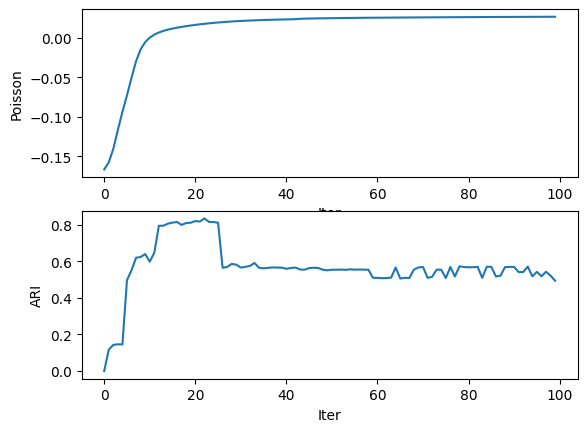

In [ ]:
monitor_perf(nmf_psn_perf, "Poisson")

# Compare NMF-SSE and NMF-Poisson
Comparing the two models, we observe that the NMF-Poisson model led to higher ARI than the NMF-SSE model. This implies that the Poisson likelihood is a better objective function to model the discrete read counts of the scRNA-seq data than the SSE loss. The latter is equivalent to maximizing the log of Gaussian likelihood.

Text(0, 0.5, 'ARI')

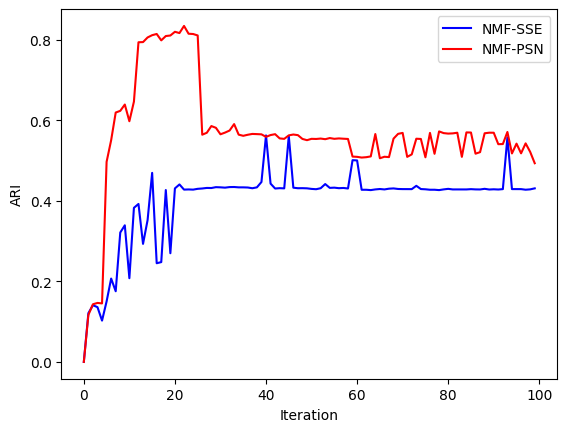

In [ ]:
# compare NMF-SSE and NMF-Poisson
fig, ax = plt.subplots()
nmf_sse_perf_df = pd.DataFrame(data=nmf_sse_perf, columns=['Iter', "SSE", 'ARI'])
nmf_psn_perf_df = pd.DataFrame(data=nmf_psn_perf, columns=['Iter', "Poisson", 'ARI'])
ax.plot(nmf_sse_perf_df["Iter"], nmf_sse_perf_df["ARI"], color='blue', label='NMF-SSE')
ax.plot(nmf_psn_perf_df["Iter"], nmf_psn_perf_df["ARI"], color='red', label='NMF-PSN')
ax.legend()
plt.xlabel("Iteration");
plt.ylabel("ARI")

# Embedding Topic Model (ETM)
The codeblock bleow implements a simpler strip-down version of the scETM (Zhao et al, 2021). The code is the same as the original ETM implementation by Dieng et al (2020) that is available from \url{https://github.com/adjidieng/ETM}.


In [ ]:
# @title ETM implementation (DO NOT MODIFY)
class ETM(nn.Module):
    def __init__(self, num_topics, vocab_size, t_hidden_size, rho_size, emsize,
                    theta_act, embeddings=None, train_embeddings=True, enc_drop=0.5):
        super(ETM, self).__init__()

        ## define hyperparameters
        self.num_topics = num_topics
        self.vocab_size = vocab_size
        self.t_hidden_size = t_hidden_size
        self.rho_size = rho_size
        self.enc_drop = enc_drop
        self.emsize = emsize
        self.t_drop = nn.Dropout(enc_drop)

        self.theta_act = self.get_activation(theta_act)

        self.train_embeddings = train_embeddings

        ## define the word embedding matrix \rho
        if self.train_embeddings:
            self.rho = nn.Parameter(torch.randn(vocab_size, rho_size)) # V x L
        else:
            self.rho = embeddings.clone().float().to(device) # V x L

        ## define the matrix containing the topic embeddings
        self.alphas = nn.Linear(rho_size, num_topics, bias=False)#nn.Parameter(torch.randn(rho_size, num_topics))

        ## define variational distribution for \theta_{1:D} via amortizartion
        self.q_theta = nn.Sequential(
                nn.Linear(vocab_size, t_hidden_size),
                self.theta_act,
                nn.Linear(t_hidden_size, t_hidden_size),
                self.theta_act,
            )
        self.mu_q_theta = nn.Linear(t_hidden_size, num_topics, bias=True)
        self.logsigma_q_theta = nn.Linear(t_hidden_size, num_topics, bias=True)

    def get_activation(self, act):
        if act == 'tanh':
            act = nn.Tanh()
        elif act == 'relu':
            act = nn.ReLU()
        elif act == 'softplus':
            act = nn.Softplus()
        elif act == 'rrelu':
            act = nn.RReLU()
        elif act == 'leakyrelu':
            act = nn.LeakyReLU()
        elif act == 'elu':
            act = nn.ELU()
        elif act == 'selu':
            act = nn.SELU()
        elif act == 'glu':
            act = nn.GLU()
        else:
            print('Defaulting to tanh activations...')
            act = nn.Tanh()
        return act

    # theta ~ mu + std N(0,1)
    def reparameterize(self, mu, logvar):
        """Returns a sample from a Gaussian distribution via reparameterization.
        """
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def encode(self, bows):
        """Returns paramters of the variational distribution for \theta.

        input: bows
                batch of bag-of-words...tensor of shape bsz x V
        output: mu_theta, log_sigma_theta
        """
        q_theta = self.q_theta(bows)
        if self.enc_drop > 0:
            q_theta = self.t_drop(q_theta)
        mu_theta = self.mu_q_theta(q_theta)
        logsigma_theta = self.logsigma_q_theta(q_theta)

        # KL[q(theta)||p(theta)] = lnq(theta) - lnp(theta)
        kl_theta = -0.5 * torch.sum(1 + logsigma_theta - mu_theta.pow(2) - logsigma_theta.exp(), dim=-1).mean()
        return mu_theta, logsigma_theta, kl_theta

    def get_beta(self):

        ## softmax over vocab dimension
        beta = F.softmax(self.alphas(self.rho), dim=0).transpose(1, 0)
        return beta

    def get_theta(self, normalized_bows):
        mu_theta, logsigma_theta, kld_theta = self.encode(normalized_bows)
        z = self.reparameterize(mu_theta, logsigma_theta)
        theta = F.softmax(z, dim=-1)
        return theta, kld_theta

    def decode(self, theta, beta):
        res = torch.mm(theta, beta)
        preds = torch.log(res+1e-6)
        return preds

    def forward(self, bows, normalized_bows, theta=None, aggregate=True):
        ## get \theta
        if theta is None:
            theta, kld_theta = self.get_theta(normalized_bows)
        else:
            kld_theta = None

        ## get \beta
        beta = self.get_beta()

        ## get prediction loss
        preds = self.decode(theta, beta)
        recon_loss = -(preds * bows).sum(1)
        if aggregate:
            recon_loss = recon_loss.mean()
        return recon_loss, kld_theta


The code to instantiate an ETM model object is already written for you with pre-specified hyperparameters (i.e., topic number, hidden size, learning rates, weight decay penalty, etc). You want to start with these settings. Once you get the model working, you may play around with these parameters to get higher ARI. But that is not mandatory.


In [ ]:
model = ETM(num_topics=K,
            vocab_size=len(genes),
            t_hidden_size=256,
            rho_size=256,
            emsize=256,
            theta_act='relu',
            embeddings=None,
            train_embeddings=True,
            enc_drop=0.5).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1.2e-6)

# A4 Task 3 (1 point) Implementing ETM
Implement the wrapper function called `train_ETM` that uses the helper functions `train_ETM_helper` to train a ETM and another completed helper function called `get_theta` to compute cell embedding topic mixture $\mathbf{\theta}$. The latter two functions have been provided to you. **Do not modify them**.

Note here that `get_theta` takes the normalized gene counts by the total count per cell stored in `X_tensor_normalized` as the input to the encoder neural network. The final reconstruction categorical likelihood is based on the unnormalized count data stored in `X_tensor`.

PyTorch by default trace the error derivatives to calculate the gradient for backpropagation. When evaluating ARI, you want to turn off this automatic gradient trace by coding under the code block `with torch.no_grad()`.

Here ARI is computed based on the Louvain clustering the cell embedding $\mathbf{\theta}$ against the ground-truth cell types stored in the `mp_anndata` object.

In [ ]:
# train the VAE for one epoch
def train_ETM_helper(model, X_tensor, X_tensor_normalized):
    # initialize the model and loss
    model.train()
    optimizer.zero_grad()
    model.zero_grad()

    # forward and backward pass
    nll, kl_theta = model(X_tensor, X_tensor_normalized)
    loss = nll + kl_theta
    loss.backward()  # backprop gradients w.r.t. negative ELBO

    # clip gradients to 2.0 if it gets too large
    torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)

    # update model to minimize negative ELBO
    optimizer.step()

    return torch.sum(loss).item()

# get sample encoding theta from the trained encoder network
def get_theta(model, input_x):
    model.eval()
    with torch.no_grad():
        q_theta = model.q_theta(input_x)
        mu_theta = model.mu_q_theta(q_theta)
        theta = F.softmax(mu_theta, dim=-1)
        return theta

In [ ]:
def train_ETM(model, X, adata=mp_anndata, niter=1000):
    """
        :param model: the ETM model object
        :param X: NxM raw read count matrix X
        :param adata: annotated single-cell data object with ground-truth cell type information for evaluation
        :param niter: maximum number of epochs
        :return:
            1. model: trained ETM model object
            2. perf: niter-by-3 ndarray with iteration index, NELBO, and ARI as the 3 columns
    """
    # Initialize W and H with random values, ensuring they're on the GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_tensor = torch.from_numpy(np.array(X, dtype="float32"))
    sums = X_tensor.sum(1).unsqueeze(1)
    X_tensor_normalized = X_tensor / sums

    # Ensure X, W, and H are on the correct device
    X_tensor = X_tensor.to(device)
    X_tensor_normalized = X_tensor_normalized.to(device)

    # Initialize performance tracking array
    perf = torch.zeros((niter, 3), dtype=torch.float32, device=device)

    # WRITE YOUR CODE HERE
    for i in range(niter):
      perf[i, 0] = i
      perf[i, 1] = train_ETM_helper(model, X_tensor, X_tensor_normalized)
      perf[i, 2] = evaluate_ari(get_theta(model, X_tensor_normalized).cpu().numpy(), adata)



    return model, perf.cpu()

Training ETM requires many epochs because of the gradient descent updates with small learning rate. For debugging, start with 10 epochs. Once you confirm that your code is working, train ETM for 1000 epochs. Record the negative ELBO loss and ARI at each iteration and then use `monitor_perf` to display the training progress. With T4 enabled on Colab (or M1 Max on Mac), 1000 epochs take less than 5 minutes. CPU takes about 10 times longer.

In [ ]:
model, scetm_perf = train_ETM(model, X, niter=1000)

Visualize the training performance

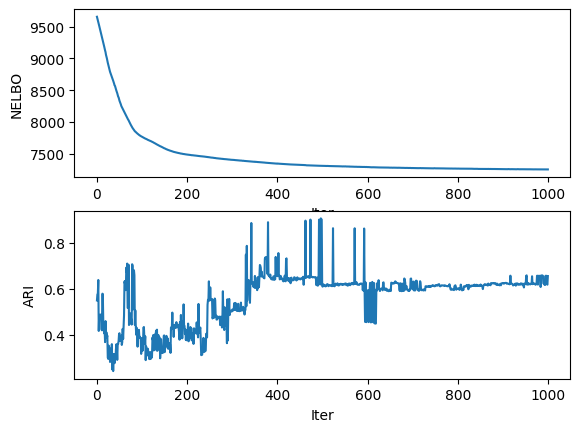

In [ ]:
monitor_perf(scetm_perf, "NELBO")

# A4 Task 4 (1 point) compare ETM with NMF-Poisson
Now run NMF-Poisson also for 1000 iterations and compare the ARI scores with scETM over the 1000 iterations. While the NMF model converges to a local optimal after only 200 iterations, the ETM continues to improve. We observe some improvement from ETM over the NMF model especially after 200 iterations. This highlights the benefits of having the non-linear encoder function and perhaps the tri-factorization design in the ETM. When training on massive number of single-cell samples, using SGD on minibatches, ETM may confer bigger improvement. For this particular dataset, with batch-effect correction, a fine-tuned ETM can reach 0.90 ARI (Zhao et al., 2021).

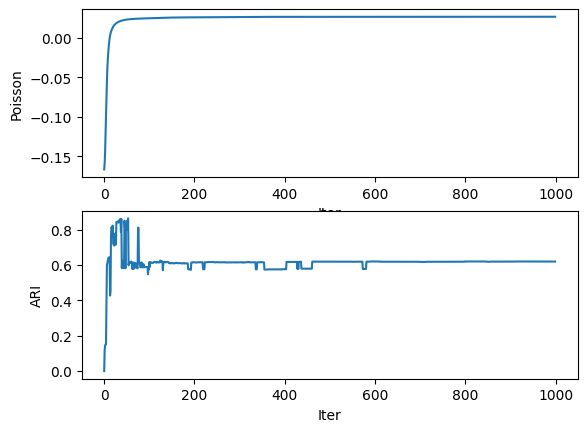

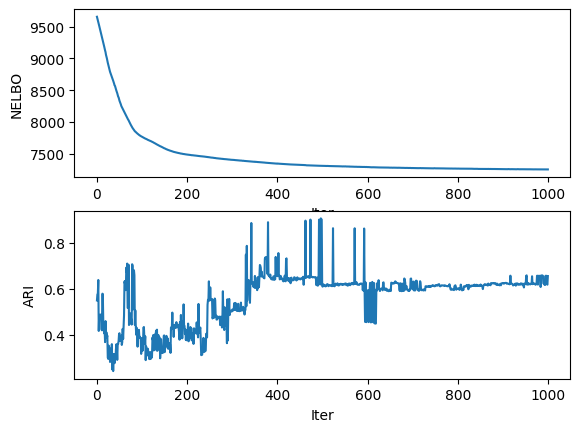

In [ ]:
# YOUR CODE HERE

#Calculating the performance for each model
W_nmf_psn, H_nmf_psn, nmf_psn_perf = nmf_psn(X.T, K, niter=1000)

#Plotting the performance of each model individually
monitor_perf(nmf_psn_perf, "Poisson")
monitor_perf(scetm_perf, "NELBO")


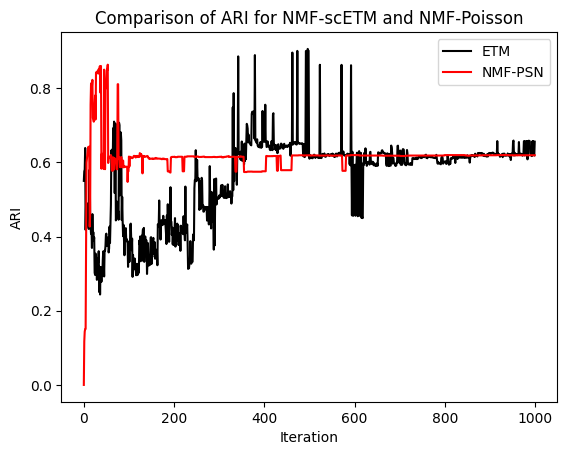

In [ ]:
# Convert the performance tensors to DataFrames
scetm_perf_df = pd.DataFrame(data=scetm_perf.cpu().numpy(), columns=['Iter', "NELBO", 'ARI'])
nmf_psn_perf_df = pd.DataFrame(data=nmf_psn_perf.cpu().numpy(), columns=['Iter', "Poisson", 'ARI'])

# Plot ARI over iterations for each model
fig, ax = plt.subplots()
ax.plot(scetm_perf_df["Iter"], scetm_perf_df["ARI"], color='black', label='ETM')
ax.plot(nmf_psn_perf_df["Iter"], nmf_psn_perf_df["ARI"], color='red', label='NMF-PSN')

# Add legend, labels, and title
ax.legend()
plt.xlabel("Iteration")
plt.ylabel("ARI")
plt.title("Comparison of ARI for NMF-scETM and NMF-Poisson")
plt.show()


# A4 Task 5 (1 point) Generate t-SNE to visualize cell embeddings
Use the `model` object of ETM saved from the previous training over the 1000 iterations to infer final cell topic embedding $\mathbf{\theta}$ and generate the two-dimensional t-SNE plot. Also, use the `H` matrix from the NMF-Poisson model (trained after 1000 iterations) to generate another two-dimensional t-SNE plot. Compare them side-by-side as shown in plots below, respectively. We observe a slightly better separation of the alpha cells from other cells from the ETM compared to the NMF-Poisson model.

The plot was generated using a `Scanpy` function called `sc.tl.tsne`. Learn how to use it from its documentation.

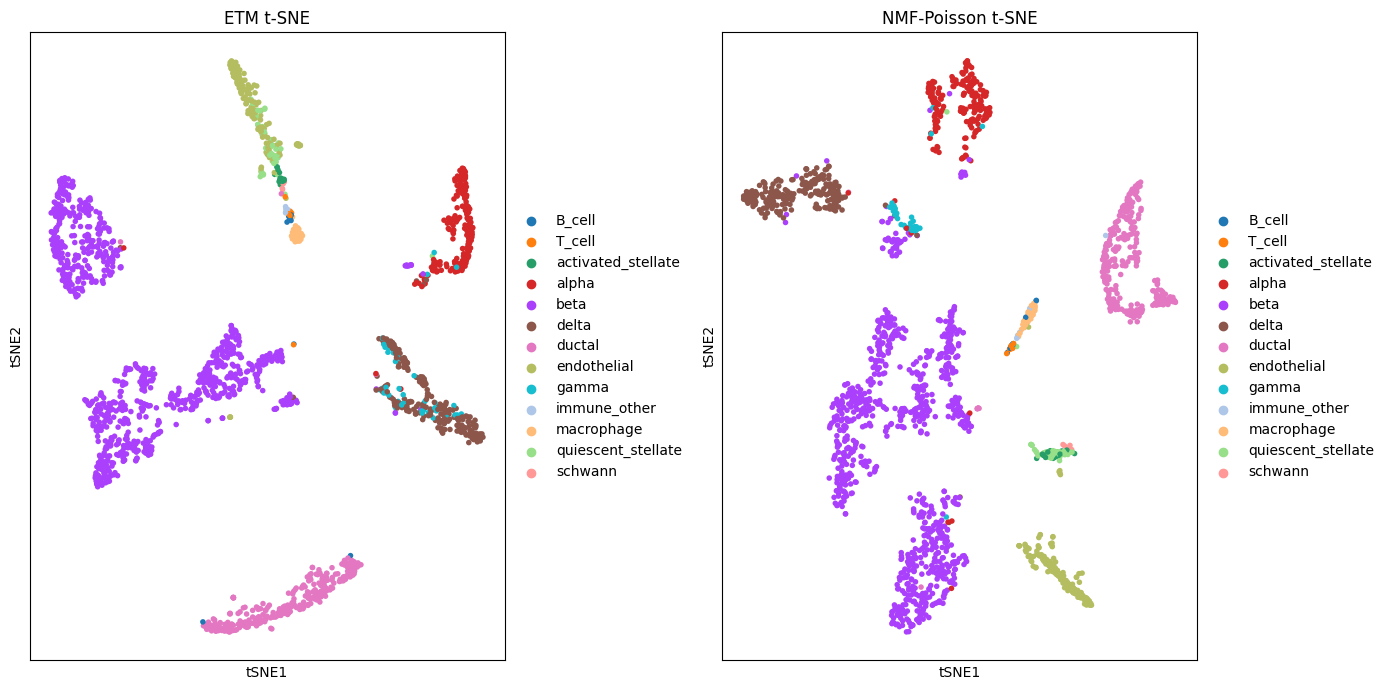

In [ ]:
# YOUR CODE HERE
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
X_tensor_normalized = X_tensor_normalized.to(device)
cell_types = mp_anndata.obs['Celltype'].values

#get the etmtheta embedding
embedding_etm = get_theta(model, X_tensor_normalized).cpu().numpy()

# convert ETM and NMF-Poisson embeddings to AnnData format, and add cell type labels so they can appear on plot
adata_etm = sc.AnnData(X=embedding_etm)
adata_nmf_psn = sc.AnnData(X=H_nmf_psn.T)
adata_etm.obs['cell_type'] = cell_types
adata_nmf_psn.obs['cell_type'] = cell_types

# run t-SNE and generate plot
sc.tl.tsne(adata_etm, n_pcs=2, perplexity=35)
sc.tl.tsne(adata_nmf_psn, n_pcs=2, perplexity=35)
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

sc.pl.tsne(adata_etm, color='cell_type', ax=axes[0], show=False, title='ETM t-SNE') # ETM
axes[0].set_xlabel("tSNE1")
axes[0].set_ylabel("tSNE2")

sc.pl.tsne(adata_nmf_psn, color='cell_type', ax=axes[1], show=False, title='NMF-Poisson t-SNE') # NMF-Poisson
axes[1].set_xlabel("tSNE1")
axes[1].set_ylabel("tSNE2")

plt.tight_layout()
plt.show()

# A4 Task 6 (1 point) Plot heatmap for the cells under each topic
An alternative way to present the cell cluster is by heatmap. Heatmap is more effective in identifying which topics correlates well with which cell types. Generate a heatmap plot for the same cells-by-topics matrix $\mathbf{\theta}$ using *all of the 1886 cells over the 16 topics*. Your heatmap should look similar to the plot below, which was generated using `seaborn.clustermap`.

From here, we see that topic 7 correlates well with alpha cell type, topic 2 with endothelial, topic 6 with ductal cell type, and so forth. Note that you will get different topic indices matching with different cell types as the order of these topics are not the same at different runs.

<ipython-input-22-b5c3aa06e777>:29: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  row_colors = adata_etm.obs['cell_type'].values.map(lut)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


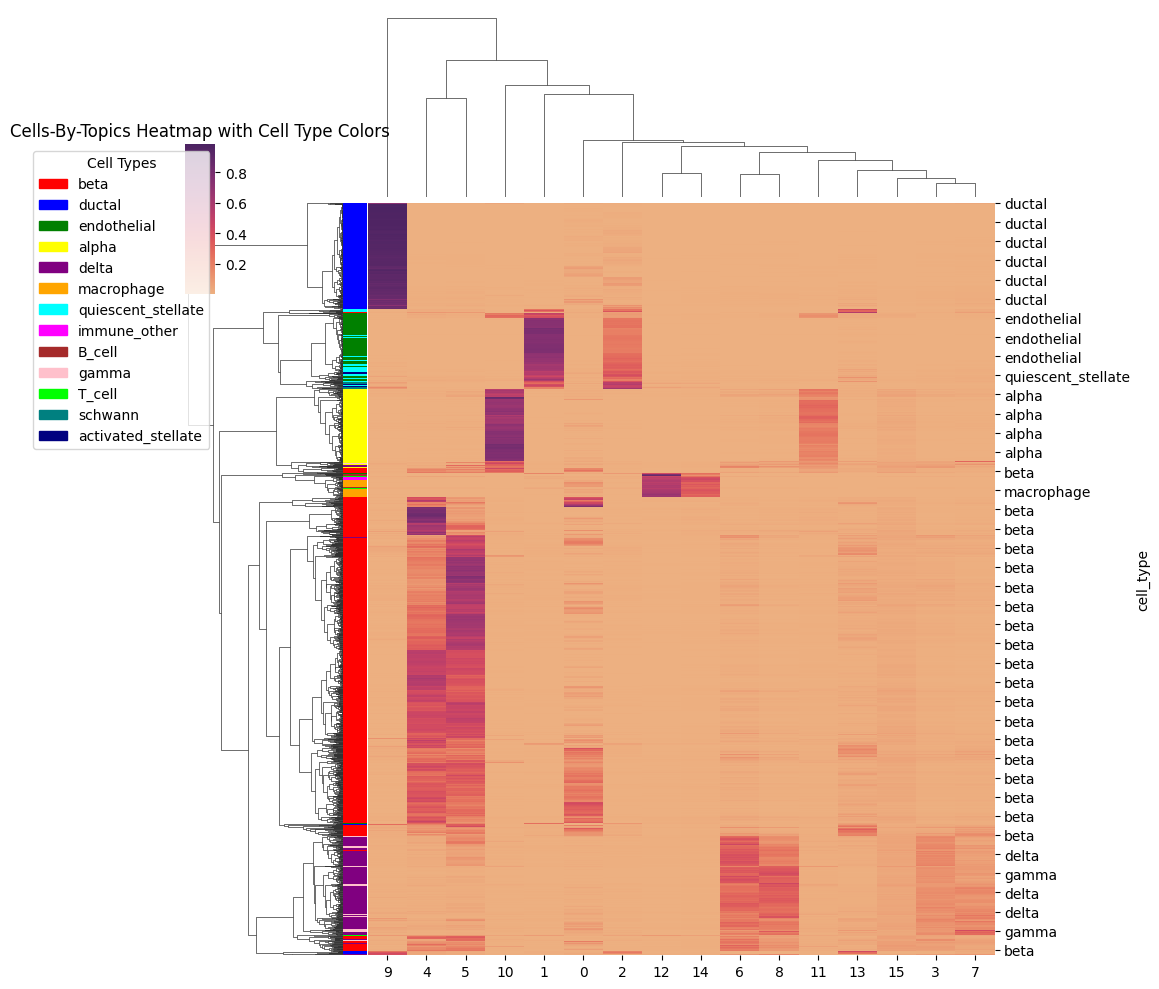

In [ ]:
# YOUR CODE HERE
import seaborn as sns
from matplotlib import cm
import matplotlib.patches as mpatches


# List of 13 unique colors for the 13 cell types
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'pink', 'lime', 'teal', 'navy']


# Creating the embedding DataFrame
embedding_etm_df = pd.DataFrame(adata_etm.X)

# Adding the cell type information as the index
embedding_etm_df['cell_type'] = adata_etm.obs['cell_type'].values
embedding_etm_df.set_index('cell_type', inplace=True)
unique_cell_types = embedding_etm_df.index.unique()



# Ensure we have exactly 13 colors for 13 unique cell types for the colour patch
if len(colors) == len(unique_cell_types):
    # Create a dictionary mapping cell types to colors
    color_mapping = dict(zip(unique_cell_types, colors))

else:
    print("The number of colors does not match the number of unique cell types.")


lut = color_mapping
row_colors = adata_etm.obs['cell_type'].values.map(lut)
sns.clustermap(
    embedding_etm_df,
    row_colors=row_colors,
    cmap=sns.color_palette("flare", as_cmap=True),
    figsize=(10, 10),
    cbar_pos=(0.02, 0.7, 0.03, 0.15)  # Adjust the color bar position
)


# Create a color patch for the legend
handles = [mpatches.Patch(color=color_mapping[cell_type], label=cell_type) for cell_type in color_mapping]
plt.legend(handles=handles, title="Cell Types", bbox_to_anchor=(1.05, 1), loc='upper right')

# Add a title
plt.title("Cells-By-Topics Heatmap with Cell Type Colors")
plt.show()



# A4 Task 7 (1 point) Plot heatmap for the top genes under each topic
To get cell-type-specific gene signature, we can visualize the genes by topics heatmap. Here we will plot the top 5 genes per topic in heatmap. Your heatmap should look similar to one below, which was generated using `seaborn.heatmap`. In plotting the heatmap, I capped the max value at 0.2 instead of letting it set to 1 to make the red intensities more prominent for some of the genes with low absolute value under some of the topics.

What cell-type-specific gene signatures can you find in your analysis? For example, from the heatmap we know that topic 7 corresponds to alpha cell type. The gene *Gcg*, which codes for protein Glucagon has the highest probability under that topic. Based on https://www.proteinatlas.org/ENSG00000115263-GCG, Glucagon is indeed a pancreatic hormone that counteracts the glucose-lowering action of insulin by stimulating glycogenolysis and gluconeogenesis!

In [ ]:
# YOUR CODE HERE

#Create a beta dataframe
beta = model.get_beta().detach().cpu()
beta_df = pd.DataFrame(beta)
beta_df
beta_df.columns = genes
df = beta_df.T


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0610009E02Rik,2.660972e-06,9.898023e-08,1.207153e-06,0.000024,0.000144,0.000065,0.000107,0.000028,0.000008,3.175117e-06,3.161148e-07,0.000046,1.467503e-06,0.000018,9.560590e-07,0.000093
0610010K14Rik,4.173788e-07,1.648781e-07,1.626914e-07,0.000201,0.000002,0.000096,0.000055,0.000122,0.000047,3.779927e-05,3.602066e-07,0.000125,6.161368e-06,0.000085,4.527492e-07,0.000016
1110002L01Rik,7.467785e-06,4.198946e-07,4.253684e-06,0.000009,0.000001,0.000076,0.000017,0.000002,0.000080,1.591861e-05,1.096489e-06,0.000008,1.014960e-06,0.000007,4.877692e-07,0.000003
1110008F13Rik,2.734578e-04,2.974847e-04,1.019375e-03,0.000354,0.000004,0.000726,0.000217,0.000057,0.000659,7.213971e-04,1.954669e-04,0.000084,4.961873e-06,0.000024,2.580590e-03,0.000002
1110020A21Rik,1.449377e-04,2.756447e-07,1.230461e-06,0.000011,0.000040,0.000029,0.000016,0.000015,0.000026,1.331301e-07,7.677015e-07,0.000051,2.610246e-06,0.000003,5.493497e-08,0.000061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zswim7,6.048692e-06,4.331064e-06,5.806032e-05,0.000026,0.000063,0.000046,0.000060,0.000052,0.000009,3.489223e-06,1.461155e-06,0.000078,2.958918e-07,0.000031,6.190208e-05,0.000034
Zw10,4.809534e-05,1.288606e-04,6.620126e-05,0.000129,0.000079,0.000261,0.000100,0.000187,0.000036,4.731454e-05,9.624637e-07,0.000026,1.009955e-05,0.000237,2.433954e-05,0.000151
Zxdc,8.043051e-06,5.763685e-05,1.186994e-06,0.000380,0.000064,0.000203,0.000193,0.000063,0.000076,7.688050e-05,1.727152e-05,0.000171,3.824309e-06,0.000537,1.528364e-04,0.000344
Zzef1,1.235018e-06,1.269684e-04,2.699305e-04,0.000085,0.000013,0.000691,0.000534,0.000253,0.000180,1.138689e-04,3.149014e-06,0.000415,7.468621e-06,0.000028,3.886874e-04,0.000188


In [ ]:

#Select only the top 5 genes per topic in the heatmap
selected_rows = []

for col in df.columns:
    top_rows = df.nlargest(5, col)
    selected_rows.append(top_rows)

selected_rows_df = pd.concat(selected_rows)


selected_rows_df = selected_rows_df.clip(upper=0.2) #We also clip all the values above 0.2 to 0.2 (instead of letting it set to 1).

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Mt1,0.200000,1.256370e-04,0.000568,0.001264,0.002487,0.000127,0.000082,0.001479,0.004302,0.003501,1.827189e-04,0.000217,0.000753,0.000787,2.112562e-04,0.000177
Mt2,0.200000,3.874618e-05,0.000022,0.000778,0.000040,0.000091,0.000298,0.000142,0.000161,0.005226,9.739416e-07,0.000504,0.000005,0.000749,2.266681e-03,0.000127
Bnip3,0.023741,1.543440e-03,0.000003,0.007773,0.010110,0.000080,0.000043,0.013310,0.000236,0.000022,4.424631e-06,0.005710,0.000249,0.000948,3.627227e-04,0.000020
Mif,0.016617,1.190123e-07,0.013000,0.009734,0.013544,0.000023,0.001502,0.001637,0.000667,0.001518,2.660715e-05,0.006810,0.003547,0.001000,4.184014e-05,0.000208
Actb,0.016509,7.155272e-03,0.048446,0.008788,0.006328,0.000337,0.000417,0.028007,0.000220,0.019047,1.217492e-04,0.008011,0.000331,0.003488,6.909032e-02,0.001077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Scg5,0.002812,4.233136e-06,0.000003,0.000040,0.006159,0.000328,0.000351,0.001449,0.000008,0.000004,1.400481e-06,0.000201,0.000013,0.000017,2.669537e-05,0.134188
Acly,0.000015,9.731632e-05,0.000360,0.000190,0.008547,0.000071,0.006990,0.000347,0.000157,0.000165,4.738119e-05,0.000306,0.000002,0.000185,1.666130e-04,0.033931
Emb,0.000032,3.161728e-06,0.000005,0.000050,0.000591,0.000011,0.000356,0.000057,0.000482,0.000005,5.370301e-06,0.000103,0.001001,0.000003,1.876252e-07,0.022227
Scg3,0.000015,2.108354e-06,0.000069,0.000053,0.034923,0.000191,0.004871,0.015006,0.000020,0.000037,2.231382e-06,0.005786,0.000005,0.002726,8.333095e-06,0.020087


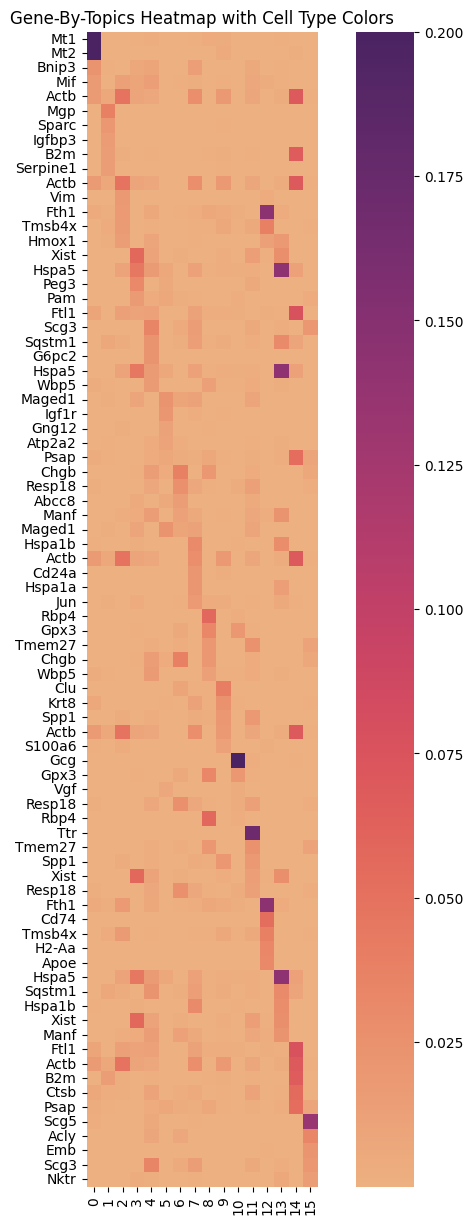

In [ ]:
#Plotting the heatmap
plt.figure(figsize=(10,15))

sns.heatmap(
    selected_rows_df,
    cmap=sns.color_palette("flare", as_cmap=True), #Changing the color for a custom color that is closer to the one expected
    square = True,
    vmax = 0.2)

#Adding a Title
plt.title("Gene-By-Topics Heatmap with Cell Type Colors")
plt.show()

Similar to the study conducted higher, we can map the expression of cells of "alpha" type to the 10th topic on the cluster map (see plot in section 6).

When observing the heatmap (plot section 7), we see that the genes with the highest probability under topic 10 include the Gcg gene, which codes for the Glucagon protein. This result is expected, as it is known that Glucagon is a pancreatic hormone that counteracts the glucose-lowering action of insulin.


Similarly, we see from the clustermap that the expression of "endothial" cells can be mapped to topic 1. Then, when observing the heatmap, we can see that the gene that is expressed with the highest probability for topic 1 is the MGP gene. This in turn echoes research that highlights the link between this gene (MGP) and this cell type (endothial).

Namely :
The Matrix Gla Protein (MGP) plays a critical role in maintaining endothelial cell function and preventing vascular calcification. MGP is highly expressed in the endothelium, where it acts as a potent inhibitor of calcification by binding to and regulating bone morphogenetic proteins (BMPs) like BMP-2, BMP-4, and BMP-7. These proteins are central to processes that, when unchecked, lead to calcification in arterial walls. In the absence of MGP, endothelial cells experience disruptions that initiate endothelial-to-mesenchymal transitions (EndMTs), leading to vascular stiffening and increased susceptibility to atherosclerosis and other cardiovascular issues

For more on this topic, see the following link  :
https://www.frontiersin.org/journals/cell-and-developmental-biology/articles/10.3389/fcell.2021.620882/full